#Environment and settings

In [ ]:
# !apt install swig
# !pip install stable-baselines3[extra]

In [1]:
from google.colab import drive
import os
import sys
import pandas as pd
import numpy as np
# import gym
drive.mount('/content/drive/',force_remount=True)
#helper directory
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase/helpers')
#file directory
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase/')
#saving directory
path = os.getcwd()
save_dir = path + '/log_RL/'
model_dir = path+ '/trained_models/'
print(f'save_dir: {save_dir}')
print(f'model_dir: {model_dir}')


Mounted at /content/drive/
save_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/log_RL/
model_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/trained_models/


In [2]:
#small helpers
import config
from helperFunction import data_split,splitByRatio  
from helperFunction import get_attributes,get_method

# # standard lib
# from gym.utils import seeding
# from gym import spaces
# from stable_baselines3.common.vec_env import DummyVecEnv
# import matplotlib.pyplot as plt
# %matplotlib inline

# Read input and split data

In [ ]:
# specify model name and logfile name
train_s = '2016-12-31' # input1
train_e = '2017-12-31' # input2
test_s = '2017-12-31'
test_e = '2018-12-31' # input3
trainY = train_s[2:4]+train_e[2:4]
nTimes = 100 # input 4
note = '42Stocks_ER' # input 5 

# log folder and model name
log_folder = f'DDPG_{nTimes}_{trainY}_{note}/'
print(f'logging to diretory: {save_dir}{log_folder}')

model_name = f'DDPG_{nTimes}_{trainY}_{note}'
print(f'model saving to: {model_dir} as {model_name}')

logging to diretory: /content/drive/MyDrive/BackUp_RL_CodeBase/log_RL/DDPG_100_1617_42Stocks_ER/
model saving to: /content/drive/MyDrive/BackUp_RL_CodeBase/trained_models/ as DDPG_100_1617_42Stocks_ER


In [3]:
# read data for environment
df=pd.read_pickle("Input/E_cleanInput.pkl")
df=df.sort_values(['tic','date'],ignore_index=True) # 218564 rows × 19 columns

In [5]:
# find first and last day of a year
pooY = pd.DataFrame()
pooY['Date'] = df.date.unique().tolist()
pooY['Year'] = [pooY.Date.iloc[i][:4] for i in range(pooY.shape[0])]
# list of years that we are interested in 
list_year = ['2014','2015','2016','2017','2018','2019','2020','2021']
ls_end = []
for year in list_year:
  temp = pooY.loc[pooY['Year'] == year]
  ind_end = temp.index.tolist()[-1] # index of last day
  ls_end.append(pooY['Date'].iloc[ind_end]) 
yearly = pd.DataFrame({'Year': list_year, 'End':ls_end})
# make training schedule further, manually
yearly

,Year,End
0,2014,2014-12-31
1,2015,2015-12-31
2,2016,2016-12-30
3,2017,2017-12-29
4,2018,2018-12-31
5,2019,2019-12-31
6,2020,2020-12-31
7,2021,2021-12-31



# Define the Environment space

In [ ]:
def traingschedule(df, test_s,test_e):
  '''generate a df of train, test start and end dates'''
  trainPeriod=21
  testPeriod=21
  # index:numeric the Testing Period 
  ls_date = df.date.unique().tolist()
  indS = ls_date.index(test_s) 
  indE = ls_date.index(test_e)
  # print(indS, indE, indE-indS, testPeriod)
  # list date
  ls_testS =[]
  ls_testE =[]
  ls_trainS =[]
  ls_trainE =[]
  trainLength = []
  testLength = []
  # indexing the dates
  for i in range(indS,indE, testPeriod):
    # exception: ensure enough test data
    if i != indS:
      # if not the first test run, equal to last testEnd-1
      testS = ls_date[ls_date.index(testE)-1]
    else:
      # if the first test run, equal to input
      testS = ls_date[i]
    # indexing the dates for training and testing, string index
    testE = ls_date[ls_date.index(testS) + trainPeriod]
    trainE = ls_date[ls_date.index(testS)]  # trainE = testS
    trainS = ls_date[ls_date.index(testS) - trainPeriod]
    # print(i,(i+testPeriod-1),(i+1),(i+1-trainPeriod))
    # computing training and testing length
    testPeriod = ls_date.index(testE) - ls_date.index(testS) 
    trainPeriod = ls_date.index(trainE) - ls_date.index(trainS) 
    # storing output
    ls_testS.append(testS)
    ls_testE.append(testE)
    ls_trainS.append(trainS)
    ls_trainE.append(trainE)
    trainLength.append(trainPeriod)
    testLength.append(testPeriod)
  trainingTable = pd.DataFrame({'trainStart':ls_trainS,'trainEnd':ls_trainE, 'trainLength': trainLength, \
                                'testStart':ls_testS,'testEnd':ls_testE, 'testLength': testLength})
  return trainingTable

In [ ]:
test_s = '2017-12-29' # last day of 2017
test_e = '2019-02-21' # last day of 2018

print(f'number of training: {df.date.unique().tolist().index(test_e) - df.date.unique().tolist().index(test_s)}')
trainingTable = traingschedule(df, test_s,test_e)
trainingTable

number of training: 293


,trainStart,trainEnd,trainLength,testStart,testEnd,testLength
0,2017-11-28,2017-12-29,21,2017-12-29,2018-01-30,21
1,2017-12-28,2018-01-29,21,2018-01-29,2018-02-27,21
2,2018-01-26,2018-02-26,21,2018-02-26,2018-03-27,21
3,2018-02-23,2018-03-26,21,2018-03-26,2018-04-26,21
4,2018-03-23,2018-04-25,21,2018-04-25,2018-05-24,21
5,2018-04-24,2018-05-23,21,2018-05-23,2018-06-21,21
6,2018-05-22,2018-06-20,21,2018-06-20,2018-07-19,21
7,2018-06-19,2018-07-18,21,2018-07-18,2018-08-16,21
8,2018-07-17,2018-08-15,21,2018-08-15,2018-09-13,21
9,2018-08-14,2018-09-12,21,2018-09-12,2018-10-11,21


In [ ]:
trainingTable.to_excel('trainingTable.xlsx')

# Make Environment

In [ ]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame, input data
        stock_dim : int, number of unique stocks
        initial_amount : int, start capital
        state_space: int, the dimension of input features
        action_space: int, equals stock dimension
        day: int, an increment number to control date
        tech_indicator_list: list, a list of technical indicator names in the dataframe
        transaction_cost_pct: float, transaction cost percentage per trade
        reward_scaling: float, scaling factor for reward, good for training

    Methods
    -------
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                transaction_cost_pct,
                state_space,
                action_space,
                lookback=252,
                day = 0):
        super(gym.Env, self).__init__() 
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim  
        self.initial_amount = initial_amount
        self.state_space = state_space
        self.action_space = action_space
        self.terminal = False  
        
        # action space is the number of stock
        self.action_space = spaces.Box(low = 0, high = 10,shape = (self.action_space,)) 
        # observation space is the daily return matrix with one year lookback period
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,self.stock_dim))

        # select remaining data for a given date, and select the return matrix for that day. that will be the state, if we don't add more
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state = self.ret
   
        # book keeper
        # date memory
        self.date_memory=[self.data.date.unique()[0]]
        self.portfolio_value = self.initial_amount
        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [1]
        # self.portfolio_return_memory = [0]
        # eq initialization, could be random if needed.
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe Ratio: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            print("Model actions: ",actions)
            weights = self.softmax_normalization(actions) 
            print("Weights: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.ret = self.data.iloc[0]['ar']
            self.state = self.ret
            
            # debug print
            print(f'Day: {self.day}')
            print(f'State: {self.state}')
            # print(f"last day memory: {last_day_memory}")
            # print(f"counter: {self.day}")
            # print(f"current day info: {self.data}")

            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            print(f'portfolio return:{portfolio_return}')
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            print(f'portfolio value:{self.portfolio_value}')
            self.portfolio_value = new_portfolio_value
            print(f"new portfolio value: {new_portfolio_value}")

            #debug print
            # print(f"close value t= {self.day} : {self.data.close.values}")
            # print(f"close value t= {self.day-1} : {last_day_memory.close.values}")
            # print(f" .......")
            # print(f"actions: {actions}")
            # print(f"weights: {weights}")
            # print(f" .......")
            # print(f"portfolio return Type: {type(portfolio_return)}")
            # print(f"portfolio return: {portfolio_return}")
            # print(f"new portfolio value Type: {type(new_portfolio_value)}")
            # print(f"new portfolio value: {new_portfolio_value}")

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value 
            # self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            # we change the reward to log portfolio return, so the reward will be additive
            self.reward = np.round(np.log(1+portfolio_return-0),4)

        return self.state, self.reward, self.terminal, {'weights':weights}

    def reset(self):
        # date and state
        self.terminal = False 
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state =self.ret
        print(f'Environment reset. Day: {self.day}, State: {self.state}')

        # bookkeeping
        self.date_memory=[self.data.date.unique()[0]] 
        self.portfolio_value = self.initial_amount
        # self.portfolio_return_memory = [0]
        self.portfolio_return_memory = [1] # using port return
        self.asset_memory = [self.initial_amount]

        #initialize action equally
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        #random initialization at rest
        # ls= np.random.default_rng(seed=0).random((42))
        # self.actions_memory = [(ls/ls.sum()).tolist()]
        # Another test
        # self.actions_memory = initWeight
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=0):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def close(self):
      pass

In [ ]:
if not os.path.exists(f'{save_dir}{log_folder}'):
    os.makedirs(f'{save_dir}{log_folder}')

In [ ]:
# #normalize the environment
# #precaution, if used, mean and std needs to be stored, problem with combining Monitor wrapper
# from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
# from stable_baselines3.common.monitor import Monitor

# # create environment, # get_attributes(e_train_gym)
# e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
# mon_env = Monitor(e_train_gym,allow_early_resets=False)
# env = DummyVecEnv([lambda:mon_env])
# e_train_gym = VecNormalize(env)

# Train model


In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

In [ ]:
def DRL_prediction(model, environment, deterministic=True):
    environment = Monitor(environment,allow_early_resets=False)
    test_env, test_obs = environment.get_sb_env()
    test_env = VecNormalize(test_env) # first allow
    """make a prediction"""
    account_memory = []
    actions_memory = []
    list_raw_acitons = []
#         state_memory=[] #add memory pool to store states
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=True)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        list_raw_acitons.append(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
#                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0], list_raw_acitons

In [ ]:
# environment setting
stock_dimension = len(df.tic.unique())
state_space =1 # 1 year lookback return, fixed in the input
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

#training schedule 
test_s = '2017-12-29' # last day of 2017
test_e = '2018-12-31' # last day of 2018
trainingTable = traingschedule(df, test_s,test_e)
trainingTable

Stock Dimension: 42, State Space: 1


,testStart,testEnd,trainStart,trainEnd
0,2017-12-29,2018-01-30,2017-01-04,2017-12-29
1,2018-01-29,2018-02-28,2017-02-02,2018-01-30
2,2018-02-27,2018-03-29,2017-03-03,2018-02-28
3,2018-03-28,2018-05-01,2017-04-03,2018-03-29
4,2018-04-30,2018-05-30,2017-05-05,2018-05-01
5,2018-05-29,2018-06-28,2017-06-05,2018-05-30
6,2018-06-27,2018-07-27,2017-07-04,2018-06-28
7,2018-07-26,2018-08-27,2017-08-02,2018-07-27
8,2018-08-24,2018-09-25,2017-08-31,2018-08-27
9,2018-09-24,2018-10-24,2017-09-29,2018-09-25


In [ ]:
# import modules
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.logger import configure
import torch as th

#input1: trainingTable
nExp = 12
# nExp = trainingTable.shape[0]
ls_s_train = trainingTable.trainStart
ls_e_train = trainingTable.trainEnd
ls_s_test = trainingTable.testStart
ls_e_test = trainingTable.testEnd

#input2: network configuration
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[100,200], vf=[100,200])])
#input3: number of trainings during one training period
nTimes = 10

# storing outputs
ls_tr_info = []
# ls_weights = []
# ls_returns = []
df_returns = pd.DataFrame(columns=['date','daily_return'])
df_actions = pd.DataFrame(columns = df.tic.unique())

# rolling forward training
for i in range(nExp):
  # 1)split data into train,create training environment  
  print(f'Progress:{i/nExp} Training Stage: building environment...')
  training = data_split(df, ls_s_train[i],ls_e_train[i])
  print(f'Rolling window {i}: training starts : {ls_s_train[i]} training ends:{ls_e_train[i]}')
  # create environment, # get_attributes(e_train_gym) 
  e_train_gym = StockPortfolioEnv(df = training, **env_kwargs)
  mon_env = Monitor(e_train_gym,allow_early_resets=False)
  env = DummyVecEnv([lambda:mon_env])
  e_train_gym = VecNormalize(env)

  # 2)define and train model
  # for continous training, model only defined once
  if i == 0:
    print(f'Progress:{i/nExp} Training Stage: configuring agent...')
    model = DDPG("MlpPolicy", env=e_train_gym , verbose=1, tensorboard_log = f'{save_dir}{log_folder}')
    # set logger directory and outputfiles
    reward_logger = configure(f'{save_dir}{log_folder}',["csv","tensorboard"])
    model.set_logger(reward_logger)
    print(f'logging to diretory: {save_dir}{log_folder}')
  # refine the model with new environment
  else:
    # save model to directory
    foldername = 'Continous/'
    mm = f'train{i-1}'# model name
    model.save(f'{model_dir}{foldername}{mm}')
    # delect model
    del model
    # reload model with new environment
    model = DDPG.load(f'{model_dir}{foldername}{mm}', env=e_train_gym)
  ######## Continou training#####  
  # train model # trainedModel.get_parameters()
  print(f'Progress:{i/nExp} Training Stage: training agent...')
  epsLen = int(training.shape[0] / len(training.tic.unique()))
  TIMESTEPS = epsLen* nTimes
  print(f'episodic length: {epsLen},training times: {nTimes}, total steps: {TIMESTEPS}')
  trainedModel = model.learn(total_timesteps=TIMESTEPS,log_interval=epsLen,\
                          callback=TensorboardCallback(),tb_log_name=f'A2C_{trainY}_{TIMESTEPS}')
  print(f'Progress:{i/nExp} Training Stage: storing training info...')
  ls_training_r = []
  for j in range(len(trainedModel.ep_info_buffer)):
    ls_training_r.append(trainedModel.ep_info_buffer[j]['r'])

  # 3)spilt data into test, create testing environment
  print(f'Progress:{i/nExp} Testing Stage: building environment...')
  testing = data_split(df, ls_s_test[i],ls_e_test[i])
  print(f'Rolling window {i}: testing starts:{ls_s_test[i]}, testing ends: {ls_e_test[i]}')
  e_test_gym = StockPortfolioEnv(df = testing, **env_kwargs)

  # 4)test model
  print(f'Progress:{i/nExp} Testing Stage: running in testing environment...')
  dfOut_daily_return, dfOut_actions, dfOut_actionsRaw = DRL_prediction(model=trainedModel,environment = e_test_gym)

  # 5)store test performance data
  ls_tr_info.append(ls_training_r) # list of training reward
  # ls_weights.append(dfOut_actions)
  # ls_returns.append(dfOut_daily_return)
  df_returns = df_returns.append(dfOut_daily_return)
  df_actions = df_actions.append(dfOut_actions)


Streaming output truncated to the last 5000 lines.
date                            
2018-06-11  0.249123  0.188997  

[1 rows x 42 columns]
portfolio return:0.007783905060611828
portfolio value:1.0687808755917836
new portfolio value: 1.0771001644579876
Model actions:  [10.        0.       10.       10.       10.        0.       10.
 10.        0.        0.        0.       10.       10.        0.
  0.       10.        0.        0.        0.       10.       10.
  0.        0.        0.        0.       10.        9.804568 10.
 10.        0.       10.        0.        0.       10.       10.
  0.       10.       10.       10.       10.       10.       10.      ]
Weights:  [4.1975718e-02 1.9056946e-06 4.1975718e-02 4.1975718e-02 4.1975718e-02
 1.9056946e-06 4.1975718e-02 4.1975718e-02 1.9056946e-06 1.9056946e-06
 1.9056946e-06 4.1975718e-02 4.1975718e-02 1.9056946e-06 1.9056946e-06
 4.1975718e-02 1.9056946e-06 1.9056946e-06 1.9056946e-06 4.1975718e-02
 4.1975718e-02 1.9056946e-06 1.9056946e-

In [ ]:
# #non Continous training
# # import modules
# from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3 import DDPG
# from stable_baselines3.common.logger import configure
# import torch as th

# #input1: trainingTable
# nExp = 2
# # nExp = trainingTable.shape[0]
# ls_s_train = trainingTable.trainStart
# ls_e_train = trainingTable.trainEnd
# ls_s_test = trainingTable.testStart
# ls_e_test = trainingTable.testEnd

# #input2: network configuration
# policy_kwargs = dict(activation_fn=th.nn.ReLU,
#                      net_arch=[dict(pi=[100,200], vf=[100,200])])
# #input3: number of trainings during one training period
# nTimes = 1

# # storing outputs
# ls_tr_info = []
# # ls_weights = []
# # ls_returns = []
# df_returns = pd.DataFrame(columns=['date','daily_return'])
# df_actions = pd.DataFrame(columns = df.tic.unique())

# # rolling forward training
# for i in range(nExp):
#   # 1)split data into train,create training environment  
#   print(f'Progress:{i/nExp} Training Stage: building environment...')
#   training = data_split(df, ls_s_train[i],ls_e_train[i])
#   print(f'Rolling window {i}: training starts : {ls_s_train[i]} training ends:{ls_e_train[i]}')
#   # create environment, # get_attributes(e_train_gym) 
#   e_train_gym = StockPortfolioEnv(df = training, **env_kwargs)
#   mon_env = Monitor(e_train_gym,allow_early_resets=False)
#   env = DummyVecEnv([lambda:mon_env])
#   e_train_gym = VecNormalize(env)

#   # 2)define and train model
#   # for continous training, model only defined once
#   if i == 0:
#     print(f'Progress:{i/nExp} Training Stage: configuring agent...')
#     model = DDPG("MlpPolicy", env=e_train_gym , verbose=1, tensorboard_log = f'{save_dir}{log_folder}')
#     # set logger directory and outputfiles
#     reward_logger = configure(f'{save_dir}{log_folder}',["csv","tensorboard"])
#     model.set_logger(reward_logger)
#     print(f'logging to diretory: {save_dir}{log_folder}')
#   else:
#     pass
#   # train model # trainedModel.get_parameters()
#   print(f'Progress:{i/nExp} Training Stage: training agent...')
#   epsLen = int(training.shape[0] / len(training.tic.unique()))
#   TIMESTEPS = epsLen* nTimes
#   print(f'episodic length: {epsLen},training times: {nTimes}, total steps: {TIMESTEPS}')
#   trainedModel = model.learn(total_timesteps=TIMESTEPS,log_interval=epsLen,\
#                           callback=TensorboardCallback(),tb_log_name=f'A2C_{trainY}_{TIMESTEPS}')
#   print(f'Progress:{i/nExp} Training Stage: storing training info...')
#   ls_training_r = []
#   for j in range(len(trainedModel.ep_info_buffer)):
#     ls_training_r.append(trainedModel.ep_info_buffer[j]['r'])

#   # 3)spilt data into test, create testing environment
#   print(f'Progress:{i/nExp} Testing Stage: building environment...')
#   testing = data_split(df, ls_s_test[i],ls_e_test[i])
#   print(f'Rolling window {i}: testing starts:{ls_s_test[i]}, testing ends: {ls_e_test[i]}')
#   e_test_gym = StockPortfolioEnv(df = testing, **env_kwargs)

#   # 4)test model
#   print(f'Progress:{i/nExp} Testing Stage: running in testing environment...')
#   dfOut_daily_return, dfOut_actions, dfOut_actionsRaw = DRL_prediction(model=trainedModel,environment = e_test_gym)

#   # 5)store test performance data
#   ls_tr_info.append(ls_training_r) # list of training reward
#   # ls_weights.append(dfOut_actions)
#   # ls_returns.append(dfOut_daily_return)
#   df_returns = df_returns.append(dfOut_daily_return)
#   df_actions = df_actions.append(dfOut_actions)


In [ ]:
# cleaning the df_returns -> dfc_returns
tempInit = df_returns.iloc[:1] # select the first observation
tempApp = df_returns[df_returns.daily_return != 1] # remove initial positions
dfc_returns = tempInit.append(tempApp)
#extra cleaning
dfc_returns = dfc_returns.reset_index()
dfc_returns.set_index('date')

# cleaning the df_actions -> dfc_actions
df_actions.index.name = 'date' # add index
dfc_actions = pd.DataFrame(index=dfc_returns.date) # retrive the dates from returns as index
dfc_actions = dfc_actions.merge(df_actions, how='left',left_index=True, right_index=True) # left join does not work
dfc_actions = dfc_actions[~dfc_actions.index.duplicated(keep='first')] # remove rows with duplicate index 

In [ ]:
# # episodic information
# ls_reward = []
# for i in range(len(modela2c.ep_info_buffer)):
#   ls_reward.append(modela2c.ep_info_buffer[i]['r'])
# pd.DataFrame(ls_reward).plot()

In [ ]:
# more values to log from the env.attribute
# get_attributes(e_train_gym)

In [ ]:
# model_name = f'DDPG_{nTimes}_{trainY}_{note}'
# print(f'model saved to: {model_dir} as {model_name}')
# modela2c.save(f'{model_dir}{model_name}')
  

# Results

Plot and store results

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


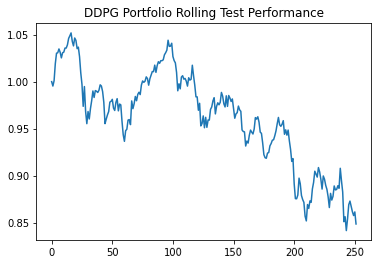

In [ ]:
dfc_returns.daily_return.iloc[0] = 0
model_cumpod =(dfc_returns.daily_return+1).cumprod()
model_cumpod.plot(title ='DDPG Portfolio Rolling Test Performance')
list_date = dfc_returns.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

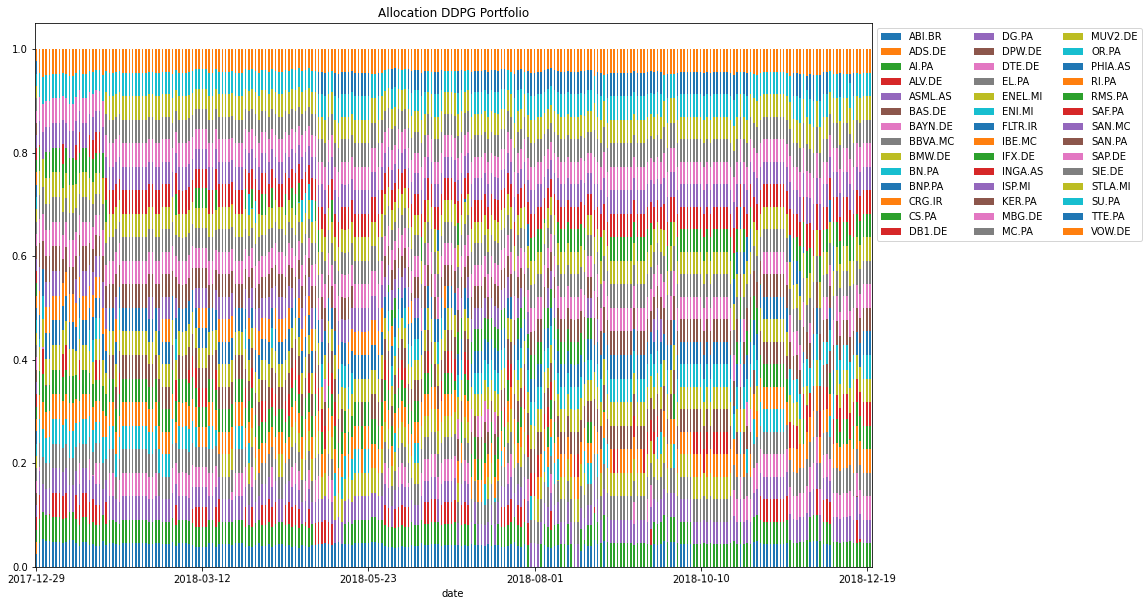

In [ ]:
list_date = dfc_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
dfc_actions.plot.bar(title ='Allocation DDPG Portfolio',figsize=(15,10),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [ ]:
result_dir =os.getcwd()+'/resultsRL/'
dfc_returns.to_csv(f'{result_dir}dailyReturnTest2018.csv',index=False)
dfc_actions.to_csv(f'{result_dir}dailyAllocationTest2018.csv',index=False)

# Reload model

In [ ]:
# # monitor wrapper 
# from stable_baselines3.common.monitor import Monitor
# e_train_gym = Monitor(e_train_gym,filename = f'{save_dir}{log_folder}')
# # reload model
# from stable_baselines3 import A2C
# model_name = f'A2C_{nTimes}_{trainY}_{note}' # model_name ='A2C_127500_1617s.zip'
# modela2c = A2C.load(f"{model_dir}{model_name}", env=e_train_gym)
# print(f'{model_name} loaded model from {model_dir}')
# # evaluate model
# from stable_baselines3.common.evaluation import evaluate_policy
# eval_return, eval_std = evaluate_policy(model = modela2c, env = e_train_gym, \
#                 n_eval_episodes=2, deterministic=True, \
#                 render=False, callback=None, \
#                 reward_threshold=None, return_episode_rewards=True, warn=True)
# print(f'average reward :{np.round(eval_return,2)} std reward : {np.round(eval_std,2)}')